In [3]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Activation, Conv3D, Dense, Dropout, Flatten, MaxPooling3D
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

2023-03-04 12:37:35.596156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 12:37:46.494385: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mukundan/anaconda3/envs/aifit/lib/
2023-03-04 12:37:46.494494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mukundan/anaconda3/envs/aifit/lib/
2023-03-04 12:37:46.494503: W tensorflow/compi

In [4]:
squat_3dcnnmodel = Sequential()
squat_3dcnnmodel.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=([32, 32, 30, 3]), padding='same'))
squat_3dcnnmodel.add(Activation('relu'))
squat_3dcnnmodel.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
squat_3dcnnmodel.add(Activation('softmax'))
squat_3dcnnmodel.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
squat_3dcnnmodel.add(Dropout(0.25))

squat_3dcnnmodel.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
squat_3dcnnmodel.add(Activation('relu'))
squat_3dcnnmodel.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
squat_3dcnnmodel.add(Activation('softmax'))
squat_3dcnnmodel.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
squat_3dcnnmodel.add(Dropout(0.25))

squat_3dcnnmodel.add(Flatten())
squat_3dcnnmodel.add(Dense(512, activation='sigmoid'))
squat_3dcnnmodel.add(Dropout(0.5))
squat_3dcnnmodel.add(Dense(2, activation='softmax'))

2023-03-04 12:38:00.357239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 12:38:01.330702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 12:38:01.330931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 12:38:01.347564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
squat_3dcnnmodel.load_weights("/home/mukundan/Desktop/VIII SEM/Data/output/squat_3dcnnmodel.hd5") #edit the path to yours
squat_3dcnnmodel.trainable = False

In [6]:
squat_3dcnnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 32, 30, 32)    2624      
                                                                 
 activation (Activation)     (None, 32, 32, 30, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 32, 30, 32)    27680     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 30, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 11, 11, 10, 32)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 10, 32)    0         
                                                        

In [7]:
import numpy as np
import cv2


class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=False):
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        return np.array(framearray)



    def get_UCF_classname(self, filename):
        return filename[filename.find('_') + 1:filename.find('_', 2)]

In [8]:
def loaddata(video_dir, vid3d, nclass, result_dir, color=False, skip=False):
    files = os.listdir(video_dir)
    print (files)
    X = []
    labels = []
    labellist = []

    pbar = tqdm(total=len(files))

    for filename in files:
        pbar.update(1)
        if filename == '.DS_Store':
            continue
        name = os.path.join(video_dir, filename)
        label = vid3d.get_classname(filename)
        print(label)
        if label not in labellist:
            if len(labellist) >= nclass:
                continue
            labellist.append(label)
        labels.append(label)
        X.append(vid3d.video3d(name, color=color, skip=skip))

    pbar.close()
    with open(os.path.join(result_dir, 'classes.txt'), 'w') as fp:
        for i in range(len(labellist)):
            fp.write('{}\n'.format(labellist[i]))

    for num, label in enumerate(labellist):
        for i in range(len(labels)):
            if label == labels[i]:
                labels[i] = num
    if color:
        return np.array(X).transpose((0, 2, 3, 4, 1)), labels
    else:
        return np.array(X).transpose((0, 2, 3, 1)), labels


In [9]:
from videoto3d_edited import Videoto3D_Edited as vid3d

In [10]:
videos = "/home/mukundan/Desktop/VIII SEM/Data/Test_2_Intermediate/" #edit the path to yours, these are pose estimation videos

img_rows = 32
img_cols = 32
depth = 30

nclass = 2
output = "/home/mukundan/Desktop/VIII SEM/Data/Test_2_Output/" #edit the path to yours
channel = 3
color = True
skip = False

frames = depth
nb_classes = nclass



In [11]:
x, y = loaddata(videos, vid3d(img_rows, img_cols, frames), nclass, output, color, skip)
print(len(x))
X = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
Y = to_categorical(y, nb_classes)

X = X.astype('float32')

['bf_27-03-03-10-43-09.mp4', 'bf_6-03-03-06-21-12.mp4', 'bf_18-03-03-10-43-09.mp4', 'bf_19-03-02-23-41-09.mp4', 'bf_37-03-03-14-53-57.mp4', 'gf_12-03-02-23-41-09.mp4', 'gf_23-03-02-23-41-09.mp4', 'gf_19-03-02-23-41-09.mp4', 'bf_28-03-02-23-41-09.mp4', 'bf_3-03-02-23-41-09.mp4', 'bf_12-03-03-06-21-12.mp4', 'bf_14-03-02-23-41-09.mp4', 'bf_21-03-03-10-43-09.mp4', 'bf_26-03-03-10-43-09.mp4', 'gf_14-03-03-14-53-57.mp4', 'gf_24-03-03-06-21-12.mp4', 'gf_25-03-03-14-53-57.mp4', 'gf_1-03-03-06-21-12.mp4', 'bf_5-03-02-23-41-09.mp4', 'bf_40-03-03-06-21-12.mp4', 'gf_26-03-02-23-41-09.mp4', 'bf_29-03-03-10-43-09.mp4', 'gf_10-03-03-10-43-09.mp4', 'gf_9-03-03-10-43-09.mp4', 'bf_22-03-02-23-41-09.mp4', 'gf_17-03-02-23-41-09.mp4', 'gf_6-03-03-06-21-12.mp4', 'bf_25-03-03-14-53-57.mp4', 'gf_13-03-03-06-21-12.mp4', 'bf_33-03-03-14-53-57.mp4', 'gf_16-03-02-23-41-09.mp4', 'bf_20-03-03-10-43-09.mp4', 'bf_9-03-03-06-21-12.mp4', 'bf_36-03-03-06-21-12.mp4', 'gf_18-03-03-06-21-12.mp4', 'bf_15-03-03-06-21-12.mp4'

  0%|          | 0/66 [00:00<?, ?it/s]

bf


  3%|▎         | 2/66 [00:02<01:26,  1.36s/it]

bf


  5%|▍         | 3/66 [00:04<01:37,  1.55s/it]

bf


  6%|▌         | 4/66 [00:05<01:27,  1.42s/it]

bf


  8%|▊         | 5/66 [00:06<01:21,  1.34s/it]

bf


  9%|▉         | 6/66 [00:08<01:21,  1.36s/it]

gf


 11%|█         | 7/66 [00:09<01:24,  1.43s/it]

gf


 12%|█▏        | 8/66 [00:11<01:33,  1.62s/it]

gf


 14%|█▎        | 9/66 [00:12<01:22,  1.45s/it]

bf


 15%|█▌        | 10/66 [00:14<01:15,  1.35s/it]

bf


 17%|█▋        | 11/66 [00:15<01:10,  1.28s/it]

bf


 18%|█▊        | 12/66 [00:16<01:09,  1.28s/it]

bf


 20%|█▉        | 13/66 [00:18<01:15,  1.43s/it]

bf


 21%|██        | 14/66 [00:19<01:08,  1.32s/it]

bf


 23%|██▎       | 15/66 [00:20<01:03,  1.24s/it]

gf


 24%|██▍       | 16/66 [00:21<01:01,  1.24s/it]

gf


 26%|██▌       | 17/66 [00:22<00:59,  1.22s/it]

gf


 27%|██▋       | 18/66 [00:23<00:54,  1.15s/it]

gf


 29%|██▉       | 19/66 [00:24<00:53,  1.14s/it]

bf


 30%|███       | 20/66 [00:26<00:53,  1.16s/it]

bf


 32%|███▏      | 21/66 [00:27<00:56,  1.25s/it]

gf


 33%|███▎      | 22/66 [00:28<00:53,  1.21s/it]

bf


 35%|███▍      | 23/66 [00:29<00:48,  1.13s/it]

gf


 36%|███▋      | 24/66 [00:30<00:45,  1.08s/it]

gf


 38%|███▊      | 25/66 [00:31<00:43,  1.06s/it]

bf


 39%|███▉      | 26/66 [00:32<00:44,  1.10s/it]

gf


 41%|████      | 27/66 [00:33<00:41,  1.08s/it]

gf


 42%|████▏     | 28/66 [00:34<00:38,  1.01s/it]

bf


 44%|████▍     | 29/66 [00:35<00:37,  1.01s/it]

gf


 45%|████▌     | 30/66 [00:37<00:40,  1.13s/it]

bf


 47%|████▋     | 31/66 [00:38<00:37,  1.08s/it]

gf


 48%|████▊     | 32/66 [00:39<00:37,  1.10s/it]

bf


 50%|█████     | 33/66 [00:40<00:36,  1.10s/it]

bf


 52%|█████▏    | 34/66 [00:41<00:36,  1.14s/it]

bf


 53%|█████▎    | 35/66 [00:42<00:35,  1.15s/it]

gf


 55%|█████▍    | 36/66 [00:43<00:32,  1.10s/it]

bf


 56%|█████▌    | 37/66 [00:44<00:30,  1.05s/it]

gf


 58%|█████▊    | 38/66 [00:45<00:31,  1.12s/it]

bf


 59%|█████▉    | 39/66 [00:47<00:32,  1.19s/it]

bf


 61%|██████    | 40/66 [00:48<00:32,  1.24s/it]

bf


 62%|██████▏   | 41/66 [00:50<00:31,  1.28s/it]

bf


 64%|██████▎   | 42/66 [00:51<00:31,  1.32s/it]

bf


 65%|██████▌   | 43/66 [00:52<00:29,  1.29s/it]

bf


 67%|██████▋   | 44/66 [00:53<00:26,  1.20s/it]

bf


 68%|██████▊   | 45/66 [00:54<00:24,  1.17s/it]

gf


 70%|██████▉   | 46/66 [00:56<00:23,  1.20s/it]

gf


 71%|███████   | 47/66 [00:57<00:25,  1.35s/it]

bf


 73%|███████▎  | 48/66 [00:58<00:22,  1.27s/it]

bf


 74%|███████▍  | 49/66 [00:59<00:19,  1.18s/it]

gf


 76%|███████▌  | 50/66 [01:00<00:17,  1.11s/it]

bf


 77%|███████▋  | 51/66 [01:01<00:16,  1.13s/it]

gf


 79%|███████▉  | 52/66 [01:02<00:15,  1.12s/it]

bf


 80%|████████  | 53/66 [01:03<00:13,  1.06s/it]

bf


 82%|████████▏ | 54/66 [01:04<00:12,  1.06s/it]

gf


 83%|████████▎ | 55/66 [01:06<00:11,  1.07s/it]

bf


 85%|████████▍ | 56/66 [01:07<00:10,  1.03s/it]

bf


 86%|████████▋ | 57/66 [01:08<00:09,  1.11s/it]

gf


 88%|████████▊ | 58/66 [01:09<00:09,  1.13s/it]

bf


 89%|████████▉ | 59/66 [01:10<00:07,  1.12s/it]

gf


 91%|█████████ | 60/66 [01:11<00:07,  1.20s/it]

bf


 92%|█████████▏| 61/66 [01:13<00:06,  1.24s/it]

bf


 94%|█████████▍| 62/66 [01:14<00:04,  1.21s/it]

gf


 95%|█████████▌| 63/66 [01:15<00:03,  1.16s/it]

gf


 97%|█████████▋| 64/66 [01:16<00:02,  1.17s/it]

bf


 98%|█████████▊| 65/66 [01:17<00:01,  1.14s/it]

gf


100%|██████████| 66/66 [01:18<00:00,  1.11s/it]

bf


100%|██████████| 66/66 [01:20<00:00,  1.21s/it]


66


In [12]:
files = os.listdir("/home/mukundan/Desktop/VIII SEM/Data/Test_2_Intermediate/") #edit the path to yours
print(files)
print(len(files))
y_pred = squat_3dcnnmodel.predict(X)


['bf_27-03-03-10-43-09.mp4', 'bf_6-03-03-06-21-12.mp4', 'bf_18-03-03-10-43-09.mp4', 'bf_19-03-02-23-41-09.mp4', 'bf_37-03-03-14-53-57.mp4', 'gf_12-03-02-23-41-09.mp4', 'gf_23-03-02-23-41-09.mp4', 'gf_19-03-02-23-41-09.mp4', 'bf_28-03-02-23-41-09.mp4', 'bf_3-03-02-23-41-09.mp4', 'bf_12-03-03-06-21-12.mp4', 'bf_14-03-02-23-41-09.mp4', 'bf_21-03-03-10-43-09.mp4', 'bf_26-03-03-10-43-09.mp4', 'gf_14-03-03-14-53-57.mp4', 'gf_24-03-03-06-21-12.mp4', 'gf_25-03-03-14-53-57.mp4', 'gf_1-03-03-06-21-12.mp4', 'bf_5-03-02-23-41-09.mp4', 'bf_40-03-03-06-21-12.mp4', 'gf_26-03-02-23-41-09.mp4', 'bf_29-03-03-10-43-09.mp4', 'gf_10-03-03-10-43-09.mp4', 'gf_9-03-03-10-43-09.mp4', 'bf_22-03-02-23-41-09.mp4', 'gf_17-03-02-23-41-09.mp4', 'gf_6-03-03-06-21-12.mp4', 'bf_25-03-03-14-53-57.mp4', 'gf_13-03-03-06-21-12.mp4', 'bf_33-03-03-14-53-57.mp4', 'gf_16-03-02-23-41-09.mp4', 'bf_20-03-03-10-43-09.mp4', 'bf_9-03-03-06-21-12.mp4', 'bf_36-03-03-06-21-12.mp4', 'gf_18-03-03-06-21-12.mp4', 'bf_15-03-03-06-21-12.mp4'

2023-03-04 12:39:33.590849: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 24330240 exceeds 10% of free system memory.
2023-03-04 12:39:34.434054: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 24330240 exceeds 10% of free system memory.
2023-03-04 12:39:47.248913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


3/3 [==============================] - 33s 100ms/step


In [34]:
df = pd.DataFrame(data=y_pred, index=files, columns = ['bf', 'gf'])
df

,bf,gf
bf_27-03-03-10-43-09.mp4,0.000441,0.999559
bf_6-03-03-06-21-12.mp4,0.012288,0.987712
bf_18-03-03-10-43-09.mp4,0.012675,0.987325
bf_19-03-02-23-41-09.mp4,0.496419,0.503581
bf_37-03-03-14-53-57.mp4,0.331669,0.668331
...,...,...
gf_4-03-03-10-43-09.mp4,0.041747,0.958253
gf_5-03-03-10-43-09.mp4,0.016271,0.983729
bf_24-03-02-23-41-09.mp4,0.050186,0.949814
gf_7-03-03-06-21-12.mp4,0.276860,0.723140


In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [15]:
df = np.round(df)
df['id'] = (df.iloc[:,:] == 1).idxmax(1)
df

,bf,gf,id
bf_27-03-03-10-43-09.mp4,0.0,1.0,gf
bf_6-03-03-06-21-12.mp4,0.0,1.0,gf
bf_18-03-03-10-43-09.mp4,0.0,1.0,gf
bf_19-03-02-23-41-09.mp4,0.0,1.0,gf
bf_37-03-03-14-53-57.mp4,0.0,1.0,gf
...,...,...,...
gf_4-03-03-10-43-09.mp4,0.0,1.0,gf
gf_5-03-03-10-43-09.mp4,0.0,1.0,gf
bf_24-03-02-23-41-09.mp4,0.0,1.0,gf
gf_7-03-03-06-21-12.mp4,0.0,1.0,gf


In [16]:
df_y = pd.DataFrame(Y, columns=['bf', 'gf'])
df_y['id'] = (df_y.iloc[:,:] == 1).idxmax(1)
df_y

,bf,gf,id
0,1.0,0.0,bf
1,1.0,0.0,bf
2,1.0,0.0,bf
3,1.0,0.0,bf
4,1.0,0.0,bf
...,...,...,...
61,0.0,1.0,gf
62,0.0,1.0,gf
63,1.0,0.0,bf
64,0.0,1.0,gf


Confusion matrix, without normalization
[[ 8 32]
 [ 0 26]]
Normalized confusion matrix
[[0.2 0.8]
 [0.  1. ]]


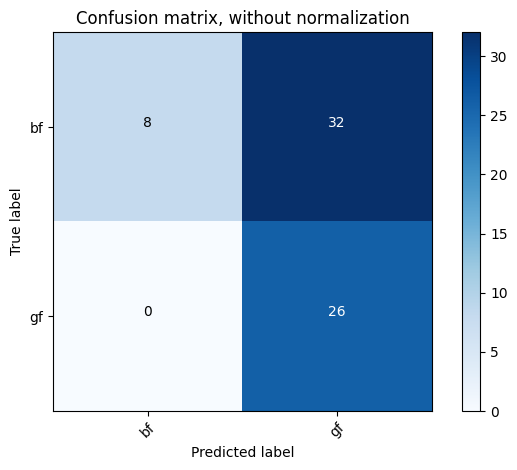

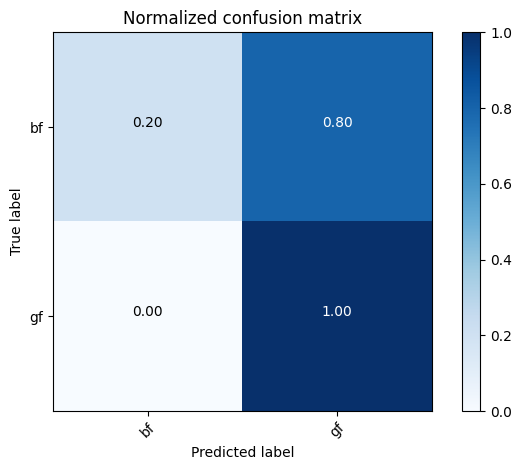

In [17]:
# Compute confusion matrix
class_names = ['bf', 'gf']
cnf_matrix = confusion_matrix(df_y['id'], df['id'])
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.savefig('confusionmatrix.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusionmatrix_normalized.png')

plt.show()

In [18]:
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.